*This jupyter notebook is part of Arizona State University's course CAS 570 (Introduction to Complex Systems Science) and was written by Bryan Daniels.  It was last updated November 4, 2024.*

*This notebook uses data gathered by Ying Wang and Robert E. Page, Jr. at Arizona State University.  The data can be accessed [here](https://figshare.com/articles/dataset/Data_Archive_for_Identifying_a_developmental_transition_in_honey_bees_using_gene_expression_data_/22696312).*

# Statistical analysis of honey bee gene expression data

In this notebook, we will practice using Principal Components Analysis to extract useful insights from a large-dimensional set of gene expression data.  We will see how a scientific question can be more easily approached when we visualize the data in a lower-dimensional space.

We will attempt to find a generative model that can output data that matches the statistics we measure in the data. In this case, the inferred model will take the form of a probability distribution of gene expression values, predicting which combinations of gene expression are more or less likely.  A typical challenge when inferring such models is selecting the best form of model:  Will a simple model suffice, or do we need to include more detail?  Here, we will use the "Bayesian information criterion" as a measure to decide which model is best.

This is part of a research project that I worked on together with Ying Wang, Rob Page, and Gro Amdam here at ASU, who are experts in honey bee physiology, behavior, and genetics.  Combining my expertise in physics and complex systems data analysis, this project is also a good example of the results of interdisciplinary collaboration.  Our writeup on the project can be found [here](https://doi.org/10.1371/journal.pcbi.1010704).

## Get set up and load the data

Let's load some useful basic packages and functions first:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from gene_expression_example.landau import LandauDistributionPDF
plt.rcParams.update({'font.size': 18}) # increases font size on plots
from pathlib import Path # to handle file paths across all operating systems

We will use the scikit learn function `sklearn.decomposition.PCA` to perform PCA.  The documentation is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [2]:
from sklearn.decomposition import PCA

Now load the data:

In [13]:
dataPath = Path('nanostring data with VG protein data.xlsx')
columnsToDrop = ['Gene','Unnamed: 2','Unnamed: 3','Sample ID','VG protein ']
expressionData = np.log(pd.read_excel(dataPath).drop(columns=columnsToDrop).set_index('Age'))

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


## What do these data represent?

These measurements were taken in honey bees at a precise time during their development (15 days old) when some bees are starting to leave the nest to forage for food.  Interestingly, some bees become foragers at a much younger age, while others stay in the nest much longer to take care of younger bees.  This transition is relatively sudden, with few bees switching back to in-nest activities once they start foraging.  There seem to be two separate "types" of bees related to which tasks they perform.  This is similar to how different cell types perform different tasks in your body.

Our question: As in cells in human development, are different bee types (those that perform distinct functions) related to which genes are expressed?

My collaborators chose genes to measure that were suspected to be related to the behavioral transition to foraging.  These data represent how strongly these genes are expressed in individual honey bees.  (Specifically, these are [measurements of the amount of RNA](https://en.wikipedia.org/wiki/RNA-Seq) present for each of the genes of interest.  We have taken the logarithm of the raw data to more easily capture wide variations in expression.)

Let's first look at the form of the data we have:

In [14]:
age = 15 # days
expressionData.loc[age]

,4ebp1,AGO1,AGO2,AKH,AKHR,AKT1,Ago3,Aub,Br-c,Chd64,...,ilp1,mdy,phosphatidylinositol 4 5-bisphosphate 3-kinase catalytic subunit delta isoform,proPO,tdc1,tdc2,ten-M,transferrin 1,vg,vgR
Age,,,,,,,,,,,,,,,,,,,,,
15,9.164485,7.168349,9.234791,4.532384,6.756735,7.471824,2.373975,5.568001,2.720637,8.365477,...,2.472328,8.275114,6.147421,7.164063,0.104360,2.142416,5.520220,11.595835,12.643998,4.717427
15,9.181636,7.088876,9.169314,4.069710,6.853447,7.207282,0.652325,5.621741,2.597491,7.800659,...,2.597491,7.948336,5.793593,6.945340,0.000000,0.000000,5.775886,10.444785,12.067427,4.458640
15,9.062972,7.583685,10.533446,4.413041,5.335228,7.849780,3.460409,6.020271,4.575844,8.284429,...,1.693779,7.601887,6.514550,4.238878,1.558145,3.214064,6.325988,9.151627,8.645885,4.677677
15,9.581204,7.655012,10.942740,4.659374,7.704546,7.852513,3.151881,6.055120,2.606387,8.054653,...,0.039221,8.545456,6.500869,7.691575,0.000000,0.662688,6.104190,10.033852,9.887967,4.771278
15,9.870273,8.317932,11.250707,4.005513,8.421640,8.314149,3.843958,6.217923,3.317816,8.303616,...,0.000000,8.575209,6.936731,7.693514,0.000000,3.470412,6.120847,10.162655,9.406524,5.576593
15,9.447503,7.431163,11.055489,4.582209,7.557426,7.710120,1.759581,6.022382,4.582209,8.265226,...,2.195000,8.431402,6.709768,7.478238,0.058269,2.657458,5.562334,11.592071,12.456780,4.854917
15,9.230179,6.376557,9.352715,2.702703,7.133479,7.228802,0.000000,4.675442,0.982078,7.007854,...,0.000000,7.515148,5.408023,5.880393,0.000000,0.000000,5.154678,9.369573,8.298129,3.650139
15,9.405040,7.380144,10.662625,4.395066,7.502611,7.402939,0.000000,5.803960,1.958685,7.819861,...,1.220830,8.283903,6.176678,7.793137,0.000000,3.720862,6.203224,10.491932,10.950163,4.654817
15,9.296530,7.517287,10.467257,4.185403,7.612416,7.593057,3.652475,5.970062,2.020222,9.263858,...,3.469168,8.446077,6.629918,7.139145,0.254642,0.862890,6.125711,11.652561,12.993406,4.459103


This is a `pandas` dataframe in which the columns represent the genes (90 of them) and the rows represent 16 individual bees whose gene expression was measured.

The default when printing a dataframe to the screen is to hide as many rows and columns as necessary to fit on a screen at once without a lot of scrolling.  To see the names of all the genes in the data, we can look at the `columns` attribute:

In [15]:
expressionData.columns

Index(['4ebp1', 'AGO1', 'AGO2', 'AKH', 'AKHR', 'AKT1', 'Ago3', 'Aub', 'Br-c',
       'Chd64', 'Creb', 'Dcr1', 'Def', 'Def2', 'Dop1', 'Dop3', 'DopR2', 'E74',
       'E75', 'EcR', 'Eth', 'Ethr', 'FOXO', 'Ftz-f1', 'HR38', 'HR46', 'Hbg3',
       'Hex70a', 'Hymenoptaecin', 'ILP-2', 'IRS', 'InR1', 'InR2', 'JHBP-1',
       'JHE', 'JHEH', 'Kr-h1', 'LOC100577942', 'LOC102655054', 'LOC406144',
       'LOC409966', 'LOC410022', 'LOC412541', 'LOC413141', 'LOC413670',
       'LOC724829', 'LOC726648', 'LOC726781', 'LOC726899 GB52437', 'MRJP-3',
       'MRJP-5', 'MRJP-9', 'MRJP1', 'Malvolio', 'Mkp3', 'Mob3', 'Mtp', 'NAA35',
       'OA1 or OAR', 'P110', 'PDK1', 'PKG (For)', 'PRM1', 'PTEN', 'Rheb',
       'SVP NR2F1', 'SmG', 'TOR', 'TYR1', 'Tbh', 'USP (RXR)', 'Vas', 'cad',
       'dnmt1a', 'dnmt2', 'dnmt3', 'egfr', 'erk7', 'hex 110', 'if', 'ilp1',
       'mdy',
       'phosphatidylinositol 4 5-bisphosphate 3-kinase catalytic subunit delta isoform',
       'proPO', 'tdc1', 'tdc2', 'ten-M', 'transferrin 1

# 1) Summarize

## The distribution of individual genes

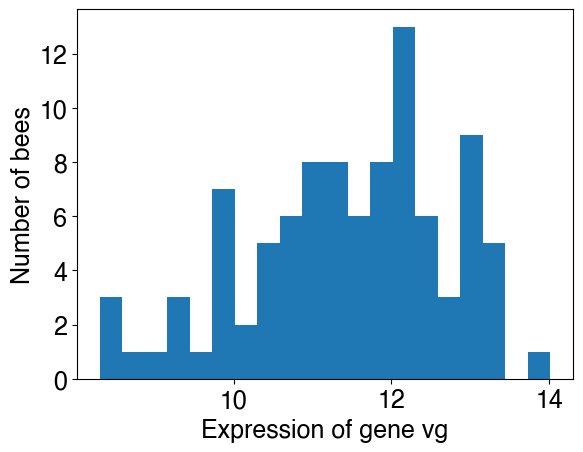

In [31]:
gene = 'vg'

# plot histogram
expressionData[gene].plot.hist(bins=20) #,density=True)
plt.xlabel('Expression of gene {}'.format(gene))
plt.ylabel('Number of bees');

In [32]:
# fit a normal distribution
paramsNormal = stats.norm.fit(expressionData[gene])
print("Best-fit parameters: mean = {:1.5}, std. dev. = {:1.5}.".format(*paramsNormal))

Best-fit parameters: mean = 11.428, std. dev. = 1.2596.


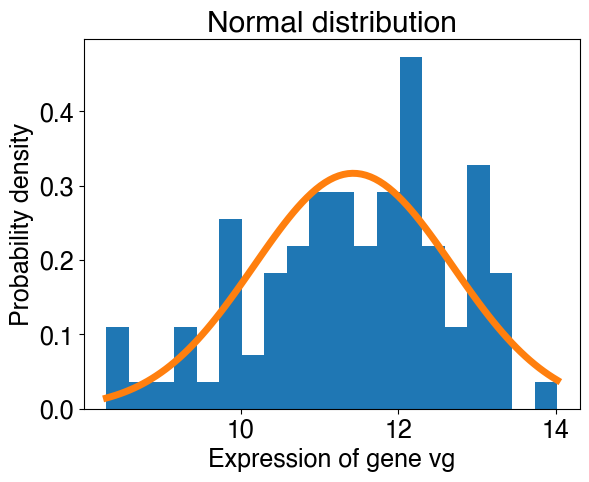

In [33]:
# plot histogram with overlaid best fit normal distribution
expressionData[gene].plot.hist(bins=20,density=True)
xs = np.linspace(min(expressionData[gene]),max(expressionData[gene]),100)
plt.plot(xs,[stats.norm.pdf(x,*paramsNormal) for x in xs],lw=5)
plt.xlabel('Expression of gene {}'.format(gene))
plt.ylabel('Probability density')
plt.title('Normal distribution');

## Try visualizing in 2D

Due to the large dimensionality of the dataset, it can be difficult to decide which aspects to focus on for thinking about our question about bee types.  Which genes are important?

One way to start is to visualize the data in lower dimensions by focusing on one or a few genes of interest at a time.  An easy way to do this using `pandas` is to use the `plot.scatter` function, which takes the names of two columns and constructs a scatter plot.  For example, we can visualize the expression of the genes *vg* and *ILP-2* in our 16 bees:

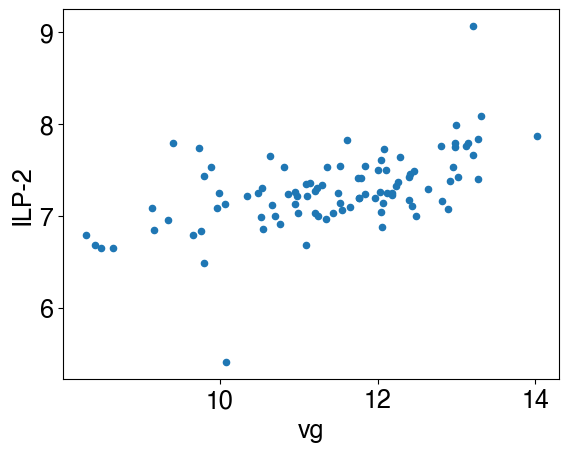

In [34]:
expressionData.plot.scatter('vg','ILP-2');

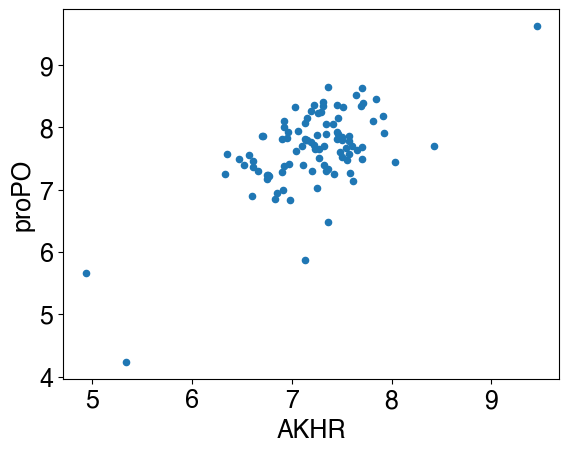

In [35]:
expressionData.plot.scatter('AKHR','proPO');

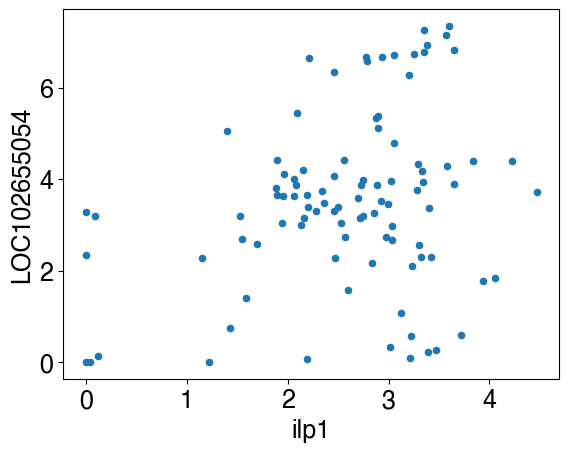

In [36]:
expressionData.plot.scatter('ilp1','LOC102655054');

As I initially played around with these data, I happened to find that the pair of genes *vg* and *P110* made for an intriguing scatter plot, particularly when restricting to the oldest bees (age 15 days):

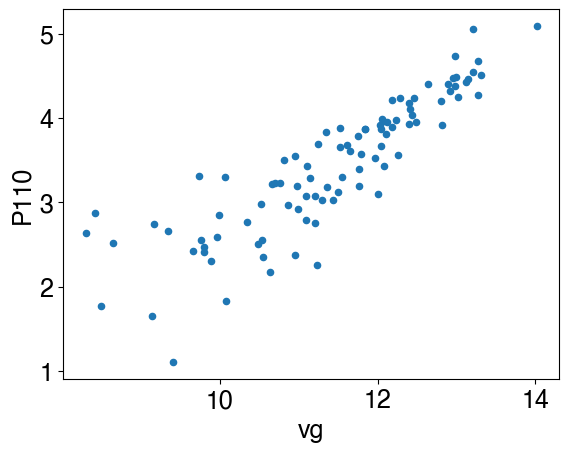

In [37]:
expressionData.plot.scatter('vg','P110');

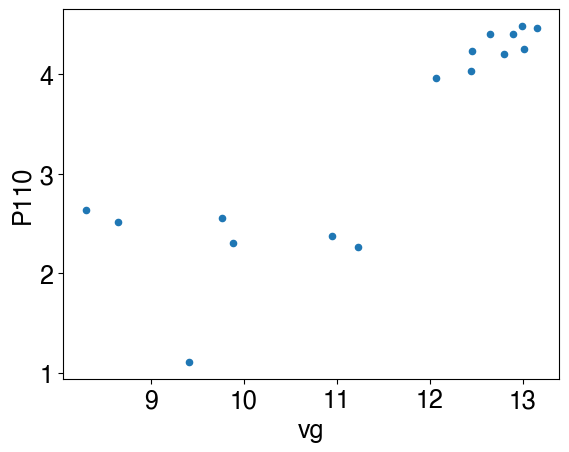

In [38]:
expressionData.loc[15].plot.scatter('vg','P110');

# 2) Predict

In [39]:
correlations = expressionData.corr()
# remove correlations with self
for gene in correlations.index:
    correlations.loc[(gene,gene)] = None

In [40]:
# find the pair of genes with largest correlation
gene1 = correlations.max().idxmax()
gene2 = correlations.idxmax()[gene1]
print("The pair of genes with largest linear correlation is {} and {}.".format(gene1,gene2))
r,p = stats.pearsonr(expressionData[gene1],expressionData[gene2])
print("These have a correlation coefficient of {:1.5}, with p-value {:1.5}.".format(r,p))

The pair of genes with largest linear correlation is AGO1 and Ftz-f1.
These have a correlation coefficient of 0.98456, with p-value 5.9981e-73.


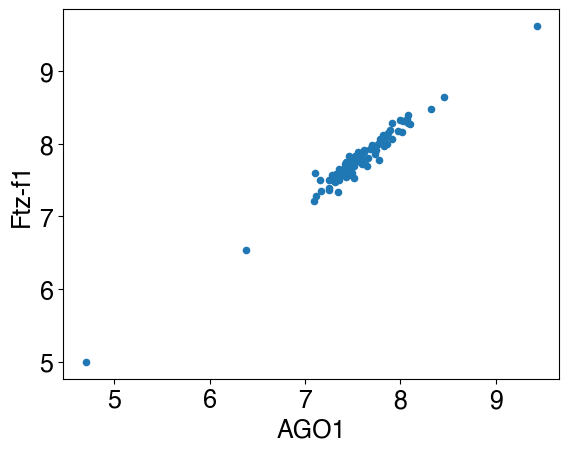

In [41]:
expressionData.plot.scatter('AGO1','Ftz-f1');

# 3) Reduce dimensionality

Instead of searching through many possible genes related to this transition, can we use dimensionality reduction to find one or a few dimensions that are particularly interesting?

Recall that Principal Components Analysis (PCA) is one way of picking out such dimensions: PCA chooses the dimensions with largest variance.  This could be useful for our question about bee types because, if gene expression varies with bee type, then we expect larger variance (and correlated variance) among the genes that define the distinct bee types.

The following code runs PCA on our expression data from the oldest bees (day 15), keeping only the 10 components with largest variance:

In [42]:
age = 15 # days
pca_results = PCA(n_components=10).fit(expressionData.loc[age])

The results are stored as attributes of the `pca_results` object, which we explore below.  (If you are curious about what all is in there, recall how tab completion works in jupyter notebooks: you can type `pca_results.` followed by the tab key to see a list of the object's subparts.)

## How low-dimensional are the data?

As a first step for thinking about what PCA is doing, let's ask how much variance there is in the data along each of these first 10 components.  Specifically, we'll ask what proportion of the total variance lies along each principal component.  This is stored as `explained_variance_ratio_`:

In [43]:
pca_results.explained_variance_ratio_

array([0.40201576, 0.20272619, 0.11717588, 0.06796019, 0.044121  ,
       0.04104241, 0.03091562, 0.024311  , 0.01973651, 0.01418387])

By construction, the first components have the largest variance (or "explain" the most variance, in the common lingo).

A common way of visualizing this is to plot the total variance included as a function of the number of principal components kept.  The following code computes this "cumulative sum" and plots it:

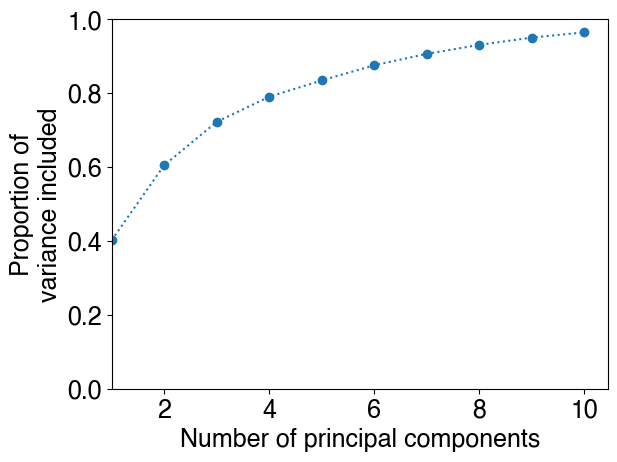

In [44]:
var_explained_cumulative = pca_results.explained_variance_ratio_.cumsum()
plt.plot(np.arange(len(var_explained_cumulative))+1,var_explained_cumulative,'o:')
plt.xlabel('Number of principal components')
plt.ylabel('Proportion of\nvariance included')
plt.axis(xmin=1,ymax=1,ymin=0);

In [45]:
var_explained_cumulative

array([0.40201576, 0.60474195, 0.72191783, 0.78987802, 0.83399901,
       0.87504143, 0.90595704, 0.93026804, 0.95000455, 0.96418842])

## Interpreting the first principal component

For our question about bee types, it makes sense to focus on the first principal component (the one with largest variance): If the dissimilarity in bee behavior is connected strongly to gene expression, then we expect these large differences in behavior to correspond to large differences in gene expression.  We are looking for large variance!

The first principal component is stored in `pca_results` as `components_[0]` (I include the names of the genes here by creating a `pandas` series indexed by the names in `expressionData.columns`):

In [57]:
component1 = pd.Series(pca_results.components_[0],
                       index = expressionData.columns)

Let's see what the first component looks like.  Recall that a principal component is defined in terms of weights given to each of the original dimensions (each of the original genes, in this case):

In [58]:
component1

4ebp1            0.003063
AGO1             0.007524
AGO2             0.085968
AKH             -0.012860
AKHR            -0.000126
                   ...   
tdc2             0.070303
ten-M            0.002387
transferrin 1   -0.140404
vg              -0.302375
vgR              0.029003
Length: 90, dtype: float64

So the principal component is a list of length 90, with a weight for each gene (either positive or negative).

I typically find it useful to visualize things when possible.  Here's one way to visualize the principal component (I split into two plots for easier leigibility):

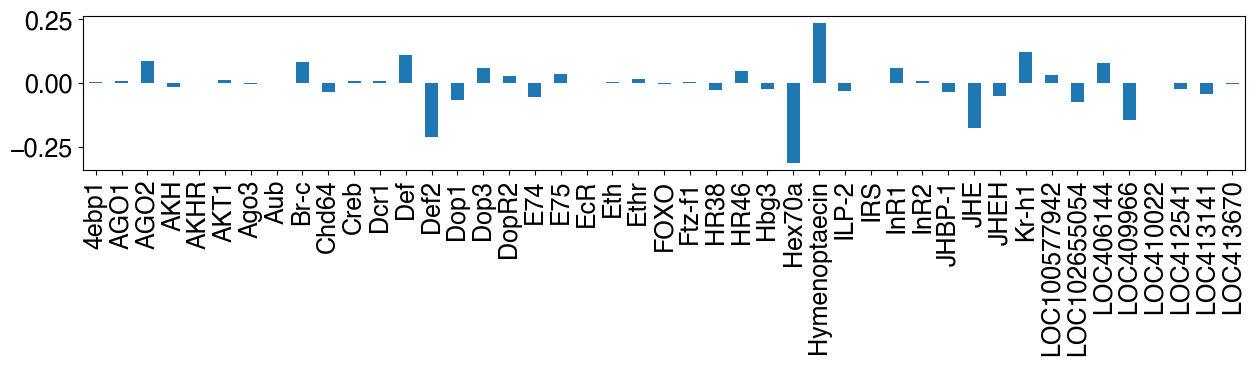

In [48]:
plt.figure(figsize=(15,2))  # set up a large plot area
component1[:45].plot.bar(); # plot the weights of the first 45 genes

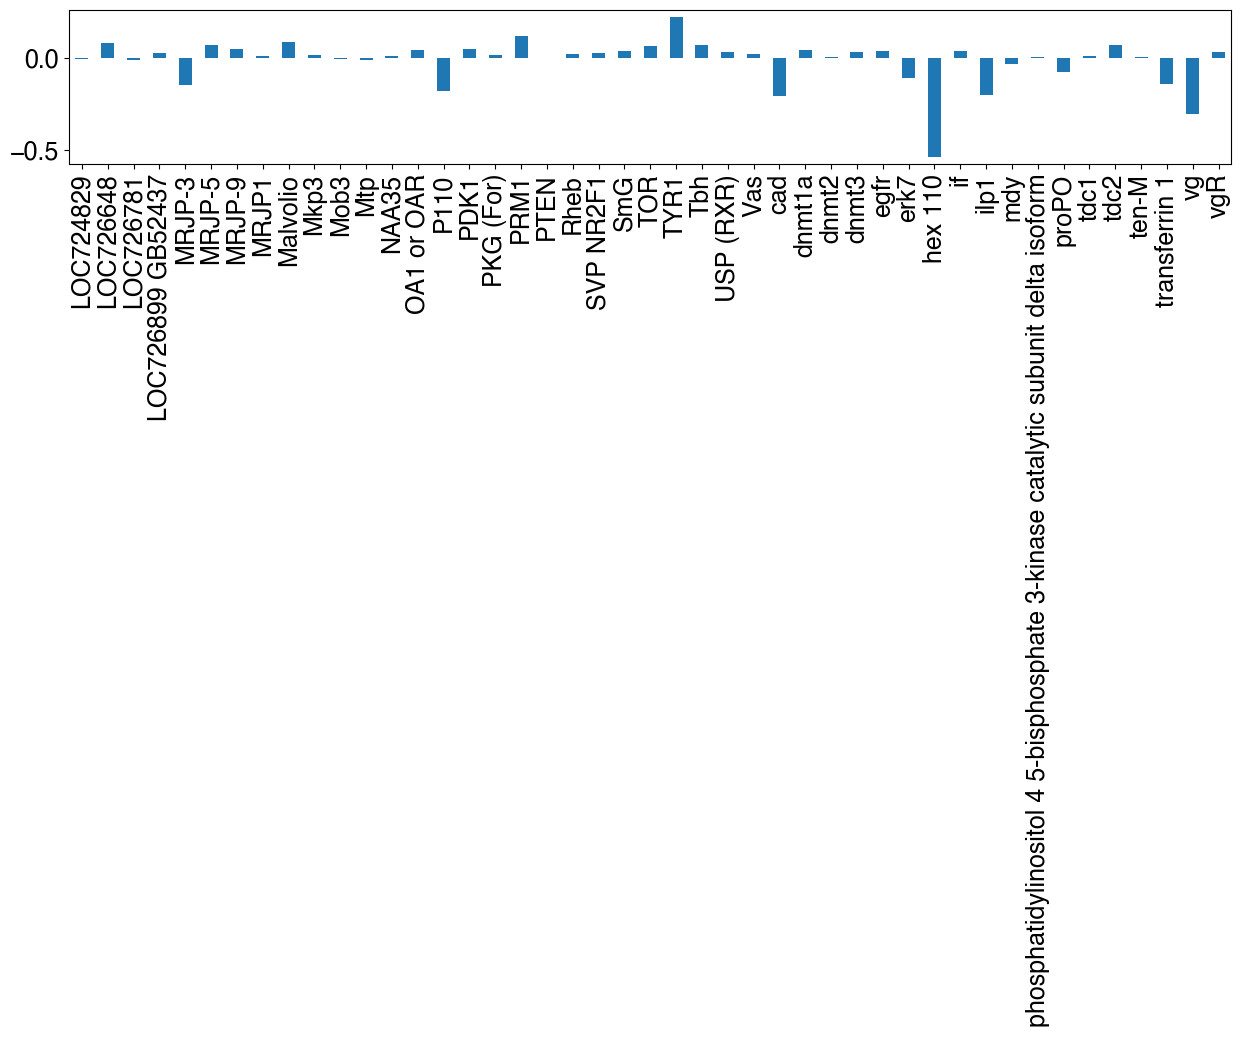

In [49]:
plt.figure(figsize=(15,2))  # set up a large plot area
component1[45:].plot.bar(); # plot the weights of all genes past the first 45

How to interpret these results?  Most genes don't contribute much to the principal component (they have small weights), and a few contribute a lot.  One way to find the genes that contribute most is to sort by the absolute value of their weight:

In [50]:
abs(component1).sort_values()

AKHR             0.000126
LOC410022        0.000388
EcR              0.000559
FOXO             0.001125
PTEN             0.001149
                   ...   
TYR1             0.221923
Hymenoptaecin    0.236389
vg               0.302375
Hex70a           0.311795
hex 110          0.535872
Length: 90, dtype: float64

So *hex 110* has the largest contribution, followed by *Hex70a*, and so on.

## Reducing data to a single dimension

Of course, the point of dimensionality reduction is that we can look at the data using these reduced coordinates.  In the extreme case, instead of the full dimensionality of the dataset, we can characterize each sample (each bee) by a *single* number.  This number is the "linear projection" of the full dimensional data onto the principal component—that is, we weight the gene expression of each bee by multiplying by the weights of the first principal component, then add them up to get a single value.

This projection, also called a "dot product", is accomplished by `np.dot`:

In [59]:
data_along_component1 = np.dot(expressionData.loc[age],component1)

Projected along the first principal component, our dataset is reduced to 16 single numbers, one for each bee:

In [60]:
data_along_component1

array([-15.63126739, -13.04299653,  -3.16372802,  -5.42634802,
        -2.85824687, -11.25177434,  -1.49494023,  -6.90329164,
       -14.52604142, -16.08666695, -14.23583234, -16.4498957 ,
       -16.07971642, -14.60239569,  -4.62466809,  -9.44652364])

We might make a histogram to visualize the data:

Text(0, 0.5, 'Number of bees')

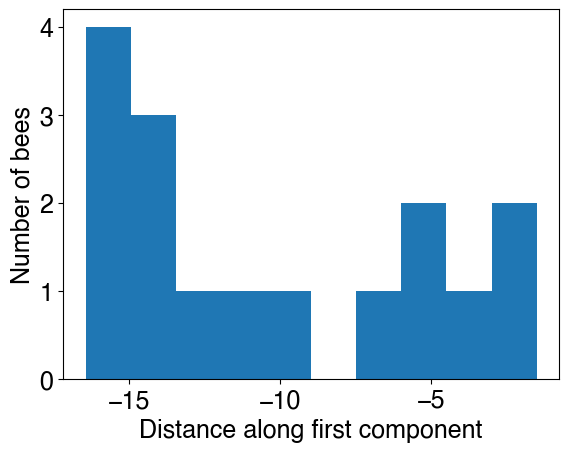

In [61]:
plt.hist(data_along_component1,bins=10)
plt.xlabel('Distance along first component')
plt.ylabel('Number of bees')

# Separate bees into potential groups

We might separate bees into groups by setting a threshold along the first principal component.

In the following code, I use a threshold of -8, splitting the bees into two groups and assigning them colors based on which group they are in.

In [54]:
threshold = -8 
beesA = np.where(data_along_component1 > threshold)[0]
beesB = np.where(data_along_component1 < threshold)[0]

# make list of colors based on the group
colors = []
for i in range(16):
    if i in beesA: 
        colors.append('crimson')
    else: 
        colors.append('cornflowerblue')

Here's an example using the colors in a scatter plot (where red dots correspond to bees in group A, and blue to group B):

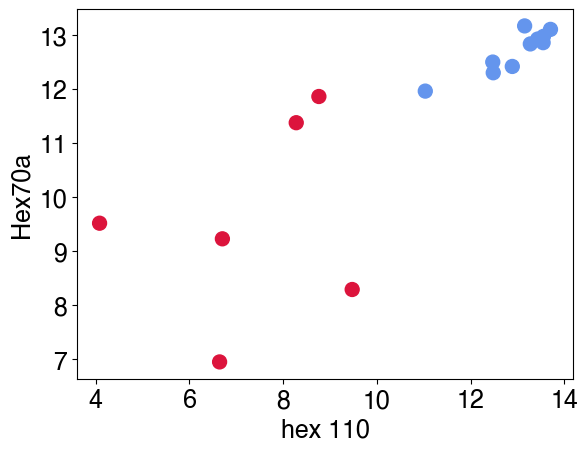

In [55]:
# largest contributors to component 1
expressionData.loc[age].plot.scatter('hex 110','Hex70a',
                            c=colors,s=100);

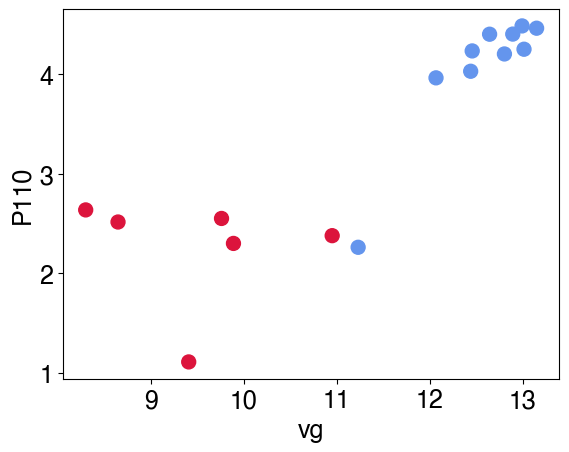

In [56]:
expressionData.loc[age].plot.scatter('vg','P110',
                            c=colors,s=100);

# 4) Simulate

Now we will aim for a generative model.  A generative model acts as a hypothesis that produces data similar to what we observed in the actual system.

In [62]:
expressionDataDay1 = expressionData.loc[1]
expressionDataDay15 = expressionData.loc[15]

pcaProjectionsDay1 = PCA(n_components=1).fit_transform(expressionDataDay1)
pcaProjectionsDay15 = PCA(n_components=1).fit_transform(expressionDataDay15)

To create a generative model, can we find a probability distribution that gives a reasonable approximation of the data along the principal component?

First try a normal distribution:

In [63]:
paramsNormalDay15 = stats.norm.fit(pcaProjectionsDay15)

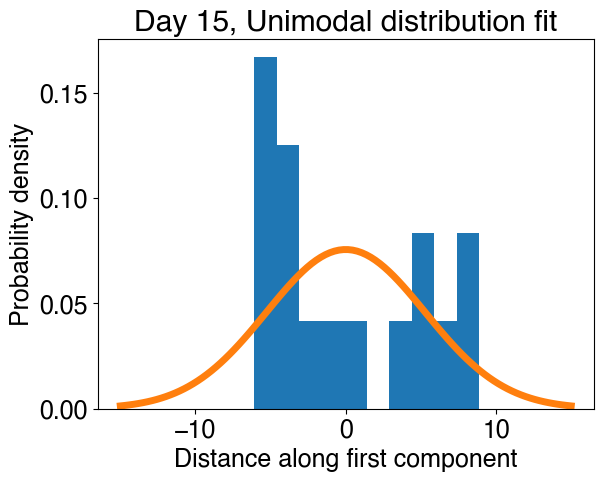

In [64]:
# plot the best-fit normal distribution
plt.hist(pcaProjectionsDay15,bins=10,density=True)
xs = np.linspace(-15,15,100)
plt.plot(xs,[stats.norm.pdf(x,*paramsNormalDay15) for x in xs],lw=5)
plt.xlabel('Distance along first component')
plt.ylabel('Probability density')
plt.title('Day 15, Unimodal distribution fit');

The function `nnlf` returns the negative log-likelihood of the data given the model, so `-nnlf` is the standard log-likelihood:

In [65]:
normalLogLDay15 = -stats.norm.nnlf(paramsNormalDay15,pcaProjectionsDay15)[0]
print("The log-likelihood for the Normal distribution model on Day 15 data is {}.".format(normalLogLDay15))

The log-likelihood for the Normal distribution model on Day 15 data is -49.314492421551904.


In a particular mathematical sense that I won't describe in detail here, the simplest distribution with *two* peaks (bimodal) is what I will call the "Landau" distribution.  This distribution corresponds to a very simplistic model of phase transitions in statistical physics. Here's the form of the distribution in case you are interested:

$$
p(x) = \frac{1}{Z} \exp \left( -\frac{c}{2} (x-\mu)^2 - \frac{d}{4} (x-\mu)^4 \right),
$$

where $Z$ is a normalization constant.  

The Landau distribution has three parameters ($\mu$, $c$, and $d$) compared to the Gaussian model's two parameters ($\mu$ and $\sigma$).  Note that the Gaussian is a special case of the Landau distribution: setting $d=0$ gives the usual form of a Gaussian.  So this model can have a single peak or two peaks depending on the values of the parameters.

The Landau distribution is not standard enough to be implemented in the packages we use here, so I've done the fitting of parameters for you.  We load these parameters here:

In [66]:
landauFitParameters = pd.read_csv(Path('gene_expression_example/landau_fit_parameters.csv'),index_col='age')

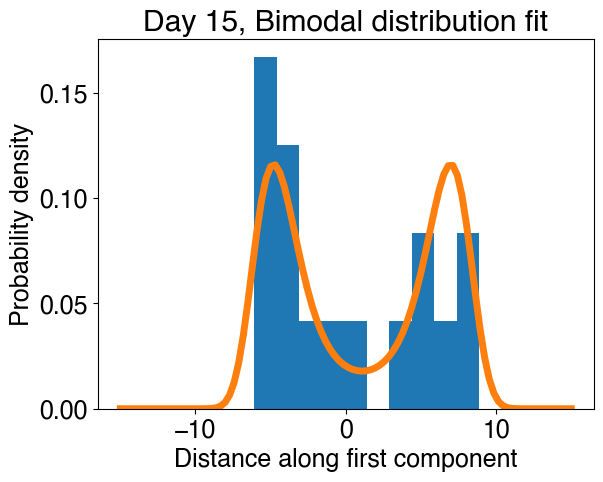

In [67]:
# plot the best-fit Landau distribution
age = 15 # age of bees in days
params = landauFitParameters.loc[age]
plt.hist(pcaProjectionsDay15,bins=10,density=True)
xs = np.linspace(-15,15,100)
plt.plot(xs,LandauDistributionPDF(xs,params['mu'],params['c'],params['d']),lw=5)
plt.xlabel('Distance along first component')
plt.ylabel('Probability density')
plt.title('Day 15, Bimodal distribution fit');

This looks like a much better fit!  Still, it's not exactly right—but then again, we only have 16 datapoints, so we don't expect the fit to be exactly right.  How do we decide if it's better enough compared to the unimodal distribution?  This is a job for statistical model selection!

First, let's look at the log-likelihood of the data given the Landau model.  I also have this pre-saved:

In [68]:
landauLogLDay15 = landauFitParameters.loc[15]['log-likelihood']
print("The log-likelihood for the Landau model on Day 15 data is {}.".format(landauLogLDay15))

The log-likelihood for the Landau model on Day 15 data is -43.02607671421029.


This is a better fit according to the log-likelihood.

But notice that the unimodal distribution is a special case of the bimodal distribution.
That is, after we have added new parameters, we could still produce the same unimodal behavior as before.

In this case, it is not possible to be forced to have a worse fit with the more complicated model — you could always just use the setting of the new parameter that gives the same answer as the simpler model.  So the new, larger model will *always* fit better, no matter the data.  (Well, I suppose it could also fit the same—it's just not possible for the fit to get worse.)

This logic means that our better fit with the more complicated model is not so impressive.  In other language we have encountered in this class, it's possible that the new, more complicated model is simply *overfitting*: fitting noise in the data.

To determine if the extra parameter is "worth the trouble", we will compute the Bayesian information criterion (BIC).  The BIC includes a penalty on more complicated models, essentially setting a bar for *how much* better a model with extra parameters must fit the data to be statistically favored.

The BIC is defined as
$$
\textrm{BIC} = L - \frac{1}{2} N_{params} \log(N_{datapoints}),
$$
where $L$ is the log-likelihood, $N_{params}$ is the number of free parameters in the model, and $N_{datapoints}$ is the number of datapoints to which the model was fit.

The following code computes BIC for the Normal and Landau models.

In [69]:
# compute bic for normal distribution model
numParamsNormal = 2
numDatapoints = 16
normalBICDay15 = normalLogLDay15 - numParamsNormal/2 * np.log(numDatapoints)

# compute bic for landau distribution model
numParamsLandau = 3
numDatapoints = 16
landauBICDay15 = landauLogLDay15 - numParamsLandau/2 * np.log(numDatapoints)

In [70]:
print("Day 15:")
print("    The Gaussian model has BIC = {} and the Landau model has BIC = {}.".format(
    normalBICDay15,landauBICDay15))
print("    The Landau model has larger BIC by a difference of {}.".format(
    landauBICDay15-normalBICDay15))

Day 15:
    The Gaussian model has BIC = -52.087081143791686 and the Landau model has BIC = -47.18495979756996.
    The Landau model has larger BIC by a difference of 4.902121346221726.


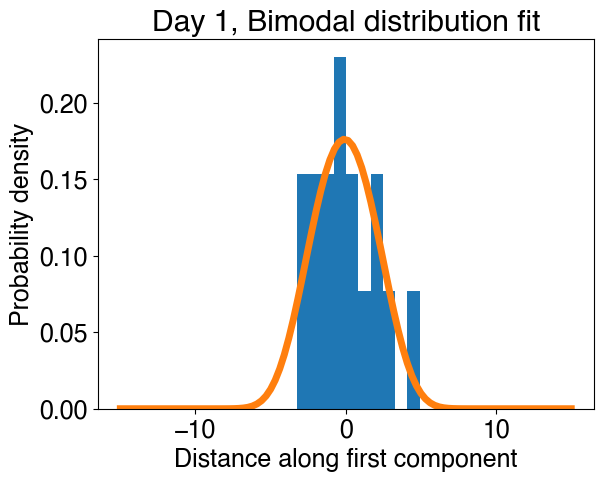

In [71]:
# plot the best-fit Landau distribution
age = 1 # age of bees in days
params = landauFitParameters.loc[age]
plt.hist(pcaProjectionsDay1,bins=10,density=True)
xs = np.linspace(-15,15,100)
plt.plot(xs,LandauDistributionPDF(xs,params['mu'],params['c'],params['d']),lw=5)
plt.xlabel('Distance along first component')
plt.ylabel('Probability density')
plt.title('Day 1, Bimodal distribution fit');

In [75]:
paramsNormalDay1 = stats.norm.fit(pcaProjectionsDay1)
normalLogLDay1 = -stats.norm.nnlf(paramsNormalDay1,pcaProjectionsDay1)[0]
print("The log-likelihood for the Normal distribution model on Day 1 data is {}.".format(normalLogLDay1))

The log-likelihood for the Normal distribution model on Day 1 data is -34.848095480489704.


In [77]:
landauLogLDay1 = landauFitParameters.loc[1]['log-likelihood']
print("The log-likelihood for the Landau model on Day 1 data is {}.".format(landauLogLDay1))

The log-likelihood for the Landau model on Day 1 data is -34.82878644056587.


In [78]:
# compute bic for normal distribution model
numParamsNormal = 2
numDatapoints = 16
normalBICDay1 = normalLogLDay1 - numParamsNormal/2 * np.log(numDatapoints)

# compute bic for landau distribution model
numParamsLandau = 3
numDatapoints = 16
landauBICDay1 = landauLogLDay1 - numParamsLandau/2 * np.log(numDatapoints)

In [80]:
print("Day 1:")
print("    The Gaussian model has BIC = {} and the Landau model has BIC = {}.".format(
    normalBICDay1,landauBICDay1))
print("    The Gaussian model has larger BIC by a difference of {}.".format(
    normalBICDay1-landauBICDay1))

Day 1:
    The Gaussian model has BIC = -37.620684202729485 and the Landau model has BIC = -38.98766952392554.
    The Gaussian model has larger BIC by a difference of 1.3669853211960543.
